# Residual Network in PyTorch

**|| Jonty Sinai ||** 13-04-2019

- **Paper:** [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
- **Authors:** Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
- **Topic:** Computer vision, Neural network architectures
- **Year:** 2015

In this notebook I implement a modularised ResNet in PyTorch. I train a simplified version of ResNet which is possible to train on a CPU in a few minutes for the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). The goal is to try and see how the different parts of ResNet can be abstracted into composeable modules.

In [1]:
%matplotlib inline

import os
import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt


HOME = os.environ['AI_HOME']
ROOT = os.path.join(HOME, 'artificial_neural_networks')
DATA = os.path.join(ROOT, 'data')
MNIST = os.path.join(DATA, 'mnist')
CIFAR10 = os.path.join(DATA, 'cifar10')

random.seed(1901)
np.random.seed(1901)
torch.manual_seed(1901)

## Deep Residual Networks

The key idea behind ResNet is to observe that if we have two networks, a shallow network and its deeper counterpart, then the deeper network should perform no worse than the shallower network if the additional layers are identity mappings from the input. 

In particular (and as outlined in the paper referenced below) let this mapping, called the _residual mapping_, be denoted by $\mathcal{H}(x)$. Then since the shallower network, let's denote it by $\mathcal{F}(x)$ differs from the residual network by the identity we have:

\begin{align}
    \mathcal{F}(x) = \mathcal{H}(x) - x
\end{align}

Now we can learn the deeper network instead:

\begin{align}
    \mathcal{H}(x) = \mathcal{F}(x) + x
\end{align}

The picture looks something like this

<img src="./assets/resnet_skip_connection.png" width="300">

source: [Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, _Deep Residual Learning for Image Recognition_, 2015](https://arxiv.org/abs/1512.03385)

So how does this help solve the vanishing gradient problem? Well let's suppose that the network with mapping $\mathcal{F}$ suffers from weight degradation, so that the input is mapped to approximately zero, then:

\begin{align}
    \mathcal{F}(x) \approx 0 \ , \ \ \lVert \mathcal{F}(x) - x \rVert \approx x
\end{align}

This means that the residual network, $\mathcal{H}$ can be used to "reset" the input if $\mathcal{F}$ has degraded:

\begin{align}
    \mathcal{H}(x) \approx x
\end{align}

With this in mind, suppose that we have stacks of such residual networks, called _residual blocks_, mapping into each other:

\begin{align}
x \rightarrow \mathcal{H}_1 \rightarrow \mathcal{H}_2 \cdots \rightarrow \mathcal{H}_L \rightarrow y
\end{align}

Then if any one of these intermediate blocks degrades, then its input will simply be reset and passed onto the next block. This allows information to be propagated through a deep network even if weights decay.

## ResNet Architecture

The architecture used in the paper is shown below:

<img src="./assets/resnet_architectures.png" width="800">

source: [Andrew Ng, Coursera](https://www.coursera.org/learn/convolutional-neural-networks/home/welcome)

Notice how ResNet has a very regular architecture, despite being very deep (especially for the time in 2015). At a high level, ResNet can be broken down into the following "sub-networks" or "blocks":

- **Convolutional block:** An initial convolutional layer with a relatively large kernel followed by a max pooling layer to quickly transform the original input image into a compressed latent representation.
- **Residual blocks:** Two layer residual blocks with skip connections (solid arrows) between them. Latent dimensionality is preserved between these blocks.
- **Transition Residual blocks:** Residual blocks which expand the number of latent channels but compress the resolution by a factor of two. Since this mapping is not dimensionality preserving, the skip connections (dashed arrows) between these blocks need to include an additional convolution layer which uses a 1x1 kernel to change dimensionality along the skip collection so that addition is possible.
- **Dense output layer:** A final dense or fully conencted layer with a softmax output.

Below we'll implement each part of ResNet modularly

## Convolution Layers

ResNet starts with an initial convolution layer with max pooling and relu activation. We'll generalise the pattern to include multiple convolution layers followed by a pooling layer and then relu.

In [2]:
class ConvBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, depth, pool):
        super().__init__()
        # first convolution layer warps dimension sizes
        self.convolution_layers = nn.ModuleList(
            [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)])
        # the remaining layers must preserve dimension size using stride = 1
        same_padding = round((kernel_size - 1) / 2)
        self.convolution_layers.extend(
            [nn.Conv2d(out_channels, out_channels, kernel_size, 1, same_padding) for _ in range(depth - 1)])
        
        if pool == "MaxPool":
            self.pool = nn.MaxPool2d(2, 2)
        elif pool == "AvgPool":
            self.pool = nn.AvgPool2d(2, 2)
        else:
            raise ValueError(f"Unsupported pooling type: {pool}!")
            
    def forward(self, x):
        for convolution in self.convolution_layers:
            x = F.relu(convolution(x))
        return F.relu(self.pool(x))


### Test Convolution Block

We can test the implementation by checking how a random tensor of arbitrary size is transformed by each neural network module.

In [3]:
test_tensor = torch.rand(10, 3, 32, 32)
conv_block = ConvBlock(3, 6, 3, 1, 1, 4, "MaxPool")
print(conv_block(test_tensor).size())

torch.Size([10, 6, 16, 16])


## Residual Blocks

We will see how we can improve on CIFAR-10 using a simple architecture with two resnet blocks. A key implementation detail is that both $x, \mathcal{F}(x) \in \mathbb{R}^d$ so that we can add them. There are two scenarios to consider here:

### Size Preserving Blocks

In this case $\mathcal{F}$ does not change the output size of $x$, so that we can simply add $x$ to $\mathcal{F}(x)$.

In [4]:
class ResBlock(nn.Module):
    
    def __init__(self, num_channels, kernel_size, depth):
        super().__init__()
        # same padding calculation
        same_padding = round((kernel_size - 1) / 2)
        # successive convolutions
        self.convolution_block = nn.ModuleList(
            [nn.Conv2d(num_channels, num_channels, kernel_size, 1, same_padding) for _ in range(depth)])
        
    def forward(self, x):
        h = x.clone()
        for convolution in self.convolution_block[:-1]:
            h = F.relu(convolution(h))
        # don't apply relu to last convolution in block
        h = self.convolution_block[-1](h)
        # add and then apply relu
        return F.relu(h + x)


### Test ResNet Block

In [5]:
test_tensor = torch.randn(10, 6, 16, 16)
res_block = ResBlock(6, 3, 4)
print(res_block(test_tensor).size())

torch.Size([10, 6, 16, 16])


### Size Transforming Blocks

In the ResNet architecture, the number of channels is progressively increased between groups of consecutive residual blocks. At the same time the resolution of the output feature map is decreased. In this case the input dimension will be different to the output dimension. In order to add $x$ to $\mathcal{F}(x)$, $x$ first passes through a convolution layer with a 1x1 kernel to warp the number of channels. Let $\mathcal{f}$ be this **transition** mapping, then the residual block is:

\begin{align}
\mathcal{F}(x) + \mathcal{f}(x)
\end{align}

This is done to keep the number of operations consistent during such transitions, every time the number of channels is increased (doubled), the output height and width is decreased (halved). This preserves the time complexity of each layer.


In [6]:
class ResBlockTransition(nn.Module):
    
    def __init__(self, in_channels, kernel_size, depth):
        super().__init__()
        padding = round((kernel_size - 1) / 2)
        # first layer doubles number of channels and halves output size
        out_channels = 2 * in_channels  
        self.convolution_block = nn.ModuleList(
            [nn.Conv2d(in_channels, out_channels, kernel_size, 2, padding)])
        # remaining layers preserve number of channels and resolution
        self.convolution_block.extend(
            [nn.Conv2d(out_channels, out_channels, kernel_size, 1, padding) for _ in range(depth - 1)])
        # transition convolution map
        self.transition = nn.Conv2d(in_channels, out_channels, 1, 2, 0)
        
    def forward(self, x):
        h = x.clone()
        for convolution in self.convolution_block[:-1]:
            h = F.relu(convolution(h))
        h = self.convolution_block[-1](h)
        x = self.transition(x)
        return F.relu(h + x)

### Test ResNet Transition Block

In [7]:
test_tensor = torch.randn(10, 6, 16, 16)
res_transition_block = ResBlockTransition(6, 3, 4)
print(res_transition_block(test_tensor).size())

torch.Size([10, 12, 8, 8])


## Dense Layers

The final part of ResNet is a fully connected layer which transforms and compresses the output of the convolutional layers into a dense representation of the output classes. We'll use the [`DenseNet`](neural_network.ipynb) module from an earlier notebook to construct arbitrary fully connected layers.

To map the output of the convolutional layers to the fully connected layer, we'll need a special flatten module which just unrolls the tensor as: 

`CxHxW -> C*H*W`.

In [8]:
class Flatten(nn.Module):
    # ref: https://discuss.pytorch.org/t/flatten-layer-of-pytorch-build-by-sequential-container/5983/3
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

### Test Flatten

In [9]:
test_tensor = torch.randn(10, 12, 4, 4)
flatten = Flatten()
print(flatten(test_tensor).size())

torch.Size([10, 192])


In [10]:
class DenseNet(nn.Module):
    
    def __init__(self, layer_dims):
        super().__init__()
        depth = len(layer_dims) - 1
        # ModuleList allows us to create differentiable layers in a Python list
        self.hidden_layers = nn.ModuleList(
                                [nn.Linear(layer_dims[i], layer_dims[i+1])
                                 for i in range(depth)])
        
    def forward(self, x):
        # ModuleList is an iterable
        for hidden in self.hidden_layers[:-1]:
            x = F.relu(hidden(x))
        # output layer
        return self.hidden_layers[-1](x)
    

### Test Dense Block

In [11]:
test_tensor = torch.randn(10, 192)
dense_block = DenseNet([192, 128, 64, 10])
print("DenseBlock:", dense_block(test_tensor).size())

DenseBlock: torch.Size([10, 10])


## Convolutional Neural Network Architecture

We'll implement ResNet as a special case of a more generalised CNN module. The idea is to sequentially compose the architecture modularly from the components defined above.

In [12]:
class ConvNetModular(nn.Module):
    
    def __init__(self, modules):
        """
        Args:
            module_arch: List of modules from which to sequentially construct
                the CNN. Modules must be specified in their order of
                computation in the architecture.
                    
        """
        super().__init__()
        
        self.layers = nn.ModuleList([module for module in modules])
                
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

### Test Modular CNN

You may have noticed that the dimensions of the test modules defined so far have been chosen so that they can be composed sequentially. We can just group these together as a list specifying the architecture.

In [13]:
arch = [conv_block,
        res_block,
        res_transition_block,
        nn.AvgPool2d(2, 2),
        flatten,
        dense_block]

In [14]:
test_tensor = torch.randn(10, 3, 32, 32)
conv_net = ConvNetModular(arch)
print("ConvNet:", conv_net(test_tensor).size())

ConvNet: torch.Size([10, 10])


## CIFAR-10 Dataset

We'll test a small and fast to train (even on a CPU) version of ResNet for CIFAR-10.

In [15]:
cifar10_transforms = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]  # note that we normalise by rank-1 tensors
                )

# Training Set
cifar10_trainset = torchvision.datasets.CIFAR10(root=CIFAR10, train=True, download=True, transform=cifar10_transforms)
cifar10_trainloader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=10, shuffle=True, num_workers=0)

# Test Set
cifar10_testset = torchvision.datasets.CIFAR10(root=CIFAR10, train=False, download=False, transform=cifar10_transforms)
cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=10, shuffle=False, num_workers=0)

cifar10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


We can preview the dataset using the following utility:

In [90]:
def preview(dataloader, classes, normalisation_statistics, model=None):
    
    mean, variance = normalisation_statistics
    
    def imshow(img, mean, variance):
        img = img / variance + mean     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)), aspect=1.5)
        plt.show()
        
    data_iter = iter(dataloader)
    images, labels = data_iter.next()
    
    # print images
    imshow(torchvision.utils.make_grid(images, nrow=10), mean, variance)
    print('Groundtruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(10)))
    
    if model:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(10)))


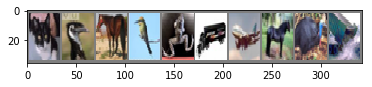

Groundtruth:    cat  bird horse  bird  frog truck plane horse  bird truck


In [47]:
preview(cifar10_trainloader, cifar10_classes, (0.5, 2))

## Experiment Utilities

Now we will create an experiment class which will manage our experiments for each model, ensuring that every part of the computation graph is kept to the local scope of the experiment.

In [83]:
class Experiment:
    
    def __init__(self, model, training_data, test_data, optimiser, loss_function):
        self.model = model
        self.training_data = training_data
        self.test_data = test_data
        self.optimiser = optimiser
        self.loss_function = loss_function
        
        self.print_preview()
        
    def start(self, num_epochs):
        self.train(num_epochs)
        self.evaluate()
        
    def train(self, num_epochs):
        print("\nTraining " + "="*81 +"\n")
    
        for epoch in range(num_epochs):
            print(f"Epoch: {epoch + 1} " + "="*80 + ">")

            total_loss = 0.0
            for batch_idx, batch in enumerate(self.training_data):
                images, labels = batch

                # zero accumulated gradients
                self.optimiser.zero_grad()

                # forward pass
                output = self.model(images)
                # backward pass
                loss = self.loss_function(output, labels)
                loss.backward()
                self.optimiser.step()

                total_loss += loss.item()
                # print progress

                if (batch_idx + 1) % 1000 == 0:    # print every 1000 mini-batches
                    print("[%4d/6000] loss: %.3f" %
                          (batch_idx + 1, total_loss / 1000))
                    total_loss = 0.0

        print("Finished Training " + "="*71 + ">")
        
    def evaluate(self):
        print("\nEvaluation: " + "="*78 +"\n")
        correct = 0
        total = 0
        with torch.no_grad():
            for data in self.test_data:
                images, truth = data
                output = self.model(images)
                _, predicted = torch.max(output.data, 1)
                total += truth.size(0)
                correct += (predicted == truth).sum().item()

        print('Test accuracy on %d test images: %.4f %%' % (total, 100 * correct / total))
        
    def print_preview(self):
        print("="*90 + "\nExperiment preview:\n" + "="*90)
        print("\nModel:\n" + "="*90)
        print(self.model)
        print("\nOptimiser:\n" + "="*90)
        print(self.optimiser)
        print("\nLoss Function:\n" + "="*90)
        print(self.loss_function)
        

## CIFAR-10 ResNet

Now let's train a simplified ResNet model for CIFAR-10.

In [84]:
resnet_cifar10 = ConvNetModular(
    [ConvBlock(in_channels=3,
               out_channels=16,
               kernel_size=3,
               stride=1,
               padding=1,
               depth=1,
               pool="MaxPool"),
     ResBlock(num_channels=16,
              kernel_size=3,
              depth=2),
     ResBlock(num_channels=16,
              kernel_size=3,
              depth=2),
     ResBlockTransition(in_channels=16,
                        kernel_size=3,
                        depth=3),
     nn.AvgPool2d(2,2),
     Flatten(),
     DenseNet([512, 10])])

cross_entropy = nn.CrossEntropyLoss()
adam = optim.Adam(resnet_cifar10.parameters(), lr=0.001)

exp1 = Experiment(resnet_cifar10, cifar10_trainloader, cifar10_testloader, adam, cross_entropy)

Experiment preview:

Model:
ConvNetModular(
  (layers): ModuleList(
    (0): ConvBlock(
      (convolution_layers): ModuleList(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ResBlock(
      (convolution_block): ModuleList(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (2): ResBlock(
      (convolution_block): ModuleList(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (3): ResBlockTransition(
      (convolution_block): ModuleList(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     

In [85]:
exp1.start(num_epochs=3)


Training =================================================================================

Epoch: 1 ================================================================================>
[1000/6000] loss: 1.831
[2000/6000] loss: 1.526
[3000/6000] loss: 1.403
[4000/6000] loss: 1.316
[5000/6000] loss: 1.264
Epoch: 2 ================================================================================>
[1000/6000] loss: 1.174
[2000/6000] loss: 1.140
[3000/6000] loss: 1.100
[4000/6000] loss: 1.057
[5000/6000] loss: 1.037
Epoch: 3 ================================================================================>
[1000/6000] loss: 0.992
[2000/6000] loss: 0.987
[3000/6000] loss: 0.957
[4000/6000] loss: 0.929
[5000/6000] loss: 0.910
Finished Training =======================================================================>

Evaluation: ==============================================================================

Test accuracy on 10000 test images: 65.8300 %


Finally we can preview a selection of images and what the model predicted their labels to be.

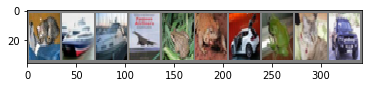

Groundtruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car
Predicted:    cat  ship  ship plane  frog  frog   car  deer   cat   car


In [91]:
preview(cifar10_testloader, cifar10_classes, (0.5, 2), model=exp1.model)